## 2023F-T3 AISC2007 - Deep Learning 

<hr>

##  Build a WGAN model to generated faces using the dataset shared in the ungraded exercise in Week 9

<hr>

### Author
**Fabio Duarte Junior**

### Teacher
**Teacher : Bhavik Gandhi**

### Description
> Use AI generative techniques to create at least 5 images of human faces that do not actually exist
> The professor provided us with a dataset of images of human beings in a variety of positions and scenarios, moods, with one or more faces, complete or partially obscured.

### My approach  

> I got Perplexity.AI and ChatGPT as my co-pilots and also class materials as reference.

> Issues :
>> 1 - Due to my OS behavior, I had to resume the process several times (for instance, when the screensaver starts, my Jupyter notebook kind of "pauses" the processing).
>> For this reason, I could not just run the entire notebook end-to-end in one go.

>> 2 - I made a mistake by not anticipating in my epoch implementations that I would have to resume the process, so the epoch numbers restarted with each resume action, 
>> ending up losing track of the true number of epochs. Fortunately, I saved all epoch metrics, so we can infer that the real number of epochs is the number of rows for the metrics.
 
>> 3 - Please ignore if you see any weird variation in the loss function; I was trying different new approaches.

>> 4 - The pre-processing of the images is not included in this code. I messed up the original pre-processing notebook, as my OpenCV stopped working in my environment and I had to change the approach.

>> But essentially, I used dlib and PIL to read each image in the repository, extract the faces, crop them from the original image, and save them into a new file.

# 00 - Libs

In [ ]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
from torchvision import datasets
from torchvision.utils import save_image
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
import os
from IPython.display import Image, display, Markdown
from tqdm import tqdm
import time
from IPython.display import clear_output
import ipywidgets as widgets
from torchvision.models import inception_v3
from torchvision import transforms
from torch.autograd import Variable
import torch.nn.functional as F
import numpy as np
from scipy.stats import entropy
from IPython.display import Image

# 01 - Data and configuration

In [2]:
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
data_root  = 'test7-small54'
img_size=64

In [3]:
## Reverse Nomalization
def scale_image(img):
    return (img+1)/2

In [4]:
transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor()
    ,transforms.Normalize(mean=(0.5), std=(0.5))
])
train_dataset    = datasets.ImageFolder(root=data_root, transform=transform)

if not os.path.exists('gan_images'):
    os.makedirs('gan_images')


In [5]:
batch_size = 100
data_loader = torch.utils.data.DataLoader(dataset    = train_dataset,                                        
                                          batch_size = batch_size,
                                          shuffle    = True)

# 02 - Discriminator and Generator architectures

In [6]:
## Discriminator
D = nn.Sequential(
    nn.Linear(img_size*img_size*3, 512), nn.LeakyReLU(0.2),
    nn.Linear(512, 256), nn.LeakyReLU(0.2),
    nn.Linear(256, 1)
)
D = D.to(device)

## Latent Dimension
latent_dim = 100

## Generator
G = nn.Sequential(
    nn.Linear(latent_dim,256) ,nn.LeakyReLU(0.2),nn.BatchNorm1d(256, momentum=0.7),
    nn.Linear(256,512)        ,nn.LeakyReLU(0.2),nn.BatchNorm1d(512, momentum=0.7),
    nn.Linear(512,1024)       ,nn.LeakyReLU(0.2),nn.BatchNorm1d(1024,momentum=0.7),
    nn.Linear(1024,img_size*img_size*3)       ,nn.Tanh()
                 )
G = G.to(device)

# 03 - Optimizer

In [7]:
## For this approach the loss is "implemented" in the model training itself. no need for cost functions
# I made this based on my simple GAN code, so I'am commenting unused parts
#criterion = nn.BCEWithLogitsLoss() 
d_optimizer = torch.optim.Adam(D.parameters(), lr=0.0002,betas=(0.5,0.999))
g_optimizer = torch.optim.Adam(G.parameters(), lr=0.0002,betas=(0.5,0.999))

# 04 - Auxiliar functions

In [8]:
## For inception score
def inception_score(imgs, cuda=False, batch_size=32, resize=False, splits=1):

    dtype = torch.FloatTensor
    dataloader = torch.utils.data.DataLoader(imgs, batch_size=batch_size)

    inception_model = inception_v3(pretrained=True, transform_input=False).type(dtype)
    inception_model.eval()
    up = torch.nn.Upsample(size=(299, 299), mode='bilinear').type(dtype)

    def get_pred(x):
        if resize:
            x = up(x)
        x = inception_model(x)
        return F.softmax(x).data.cpu().numpy()

    preds = np.zeros((len(imgs), 1000))
    for i, batch in enumerate(dataloader, 0):
        batch = batch.type(dtype)
        batchv = Variable(batch)
        batch_size_i = batch.size(0)
        preds[i*batch_size:i*batch_size + batch_size_i] = get_pred(batchv)

    split_scores = []
    
    for k in range(splits):
        part = preds[k * (len(preds) // splits): (k+1) * (len(preds) // splits), :]
        py = np.mean(part, axis=0)
        scores = []
        for i in range(part.shape[0]):
            pyx = part[i, :]
            scores.append(entropy(pyx, py))
        split_scores.append(np.exp(np.mean(scores)))

    return np.mean(split_scores), np.std(split_scores)
    
## Generate N samples and can convert to the PIL format, which is suitable for display.    
def generate_samples(model, num_images=1, latent_dim=100, return_type='PIL'):
    noise = torch.randn(num_images, latent_dim).to(device)
    with torch.no_grad():
        generated_images = model(noise).detach().cpu()

    if return_type == 'PIL':
        generated_images = [img.view(3, 64, 64) for img in generated_images]

        transform = transforms.Compose([
            transforms.ToPILImage(),
            transforms.Resize((299, 299)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ])
        generated_images = [transform(img) for img in generated_images]

    return generated_images
## To help in the display organization
def clear_cell_output():
    clear_output(wait=True)
    

# 05 - Training function

In [9]:
# Create list with zeros and ones for using it as labels
ones_ = torch.ones(batch_size,1).to(device)
zero_ = torch.zeros(batch_size,1).to(device)

# Store the losses
d_losses = list()
g_losses = list()
D_AVGLoss_list = list()
G_AVGLoss_list = list()


def run_epocs(num_epochs):
    for epoch in range(num_epochs):
        sum_D_loss = 0
        sum_G_loss = 0
        start_time = time.time()          
        for inputs, _ in data_loader:
            n = inputs.size(0)
            inputs = inputs.reshape(n, img_size*img_size*3).to(device)
            
            ## Train discriminator
            # Fake images
            noise = torch.randn(n, latent_dim).to(device)
            fake_images = G(noise)
            
            # Real images
            real_outputs = D(inputs)
            d_loss_real = -torch.mean(real_outputs)

            # Fake images (again =])
            fake_outputs = D(fake_images)
            d_loss_fake = torch.mean(fake_outputs)

            # Gradient for discriminator
            d_loss = d_loss_real + d_loss_fake
            d_optimizer.zero_grad()
            d_loss.backward()
            d_optimizer.step()

            # Clip weights of the discriminador
            for p in D.parameters():
                p.data.clamp_(-0.01, 0.01)

            # Train Generator
            # More fake images
            noise = torch.randn(n, latent_dim).to(device)
            fake_images = G(noise)
            fake_outputs = D(fake_images)

            # Gradient 
            g_loss = -torch.mean(fake_outputs)
            g_optimizer.zero_grad()
            g_loss.backward()
            g_optimizer.step()
                
            d_losses.append(d_loss.item())
            g_losses.append(g_loss.item())
            sum_D_loss += d_loss.item()
            sum_G_loss += g_loss.item()
            
        ## Variables for display metrics
        average_D_loss = sum_D_loss / len(data_loader.dataset)
        average_L_loss = sum_G_loss / len(data_loader.dataset)
        D_AVGLoss_list.append(average_D_loss)
        G_AVGLoss_list.append(average_L_loss)
        end_time        = time.time()  
        elapsed_time    = end_time - start_time 
    
        clear_cell_output ()    
        markdown_table  = "| Epoch | Discriminator AVG Loss | Generator AVG Loss | Time |\n"
        markdown_table += "|-------|------------------------|--------------------|------|\n"
        markdown_table += f"| {epoch} /{num_epochs}| **{d_loss.item():.8f}** |**{g_loss.item():.8f}** | {elapsed_time:.4f} seconds |"
    
      
        display(Markdown(markdown_table))
        fake_images = fake_images.reshape(-1,3,64,64)
        save_image(scale_image(fake_images), "gan_images/test.png",nrow=9)
        #save_image(fake_images, "gan_images/test.png",nrow=9)
    
        ## Just a bunch of code for making a good presentation of the epochs =]
        file_path = "gan_images/test.png" 
        image_widget = widgets.Image(
            value=open(file_path, "rb").read(),
            format='png',
            width=600,  
            height=600,  
        )    
        plot_widget = widgets.Output()    
    
       ## Same here
        with plot_widget:
            plt.figure(figsize=(8, 2))  
            plt.plot(g_losses, label='Generator')
            plt.plot(d_losses, label='Discriminator')
            plt.legend()
            plt.xlabel('Epochs')
            plt.ylabel('Loss')
            plt.title('Loss Variation Through Training iterations')
            plt.show()
            
            plt.figure(figsize=(8, 2))  
            plt.plot(G_AVGLoss_list)
            plt.xlabel('Epochs')
            plt.ylabel('AVG Loss')
            plt.title('Generator')
            plt.show()
            
            plt.figure(figsize=(8, 2))  
            plt.plot(D_AVGLoss_list)
            plt.xlabel('Epochs')
            plt.ylabel('AVG Loss')
            plt.title('Discriminator')
            plt.show()
            
            plt.figure(figsize=(8, 2))  
            plt.plot(G_AVGLoss_list, label='Generator')
            plt.plot(D_AVGLoss_list, label='Discriminator')
            plt.legend()
            plt.xlabel('Epochs')
            plt.ylabel('AVG Loss')
            plt.title('AVG Loss through Epocs')
            plt.show()            
           
        horizontal_layout = widgets.HBox([image_widget, plot_widget])
        

        display(Image(filename="gan_images/test.png" ))
        display(horizontal_layout)

## 06 - Running the model

| Epoch | Discriminator AVG Loss | Generator AVG Loss | Time |
|-------|------------------------|--------------------|------|
| 3084 /5000| **-0.31644869** |**1.28246522** | 1.0691 seconds |

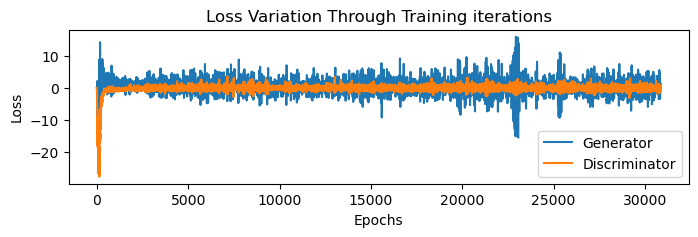

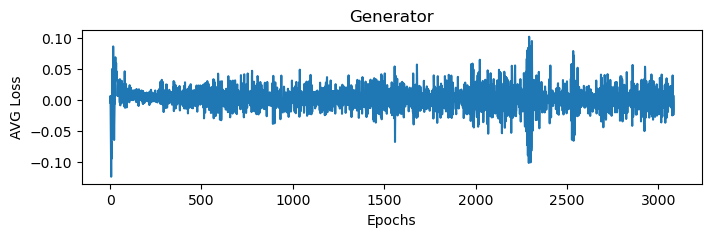

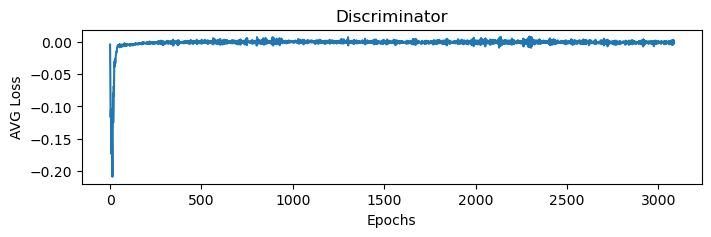

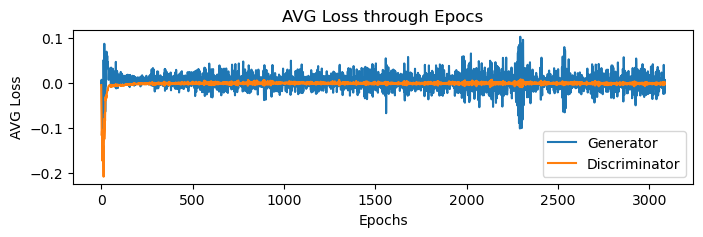

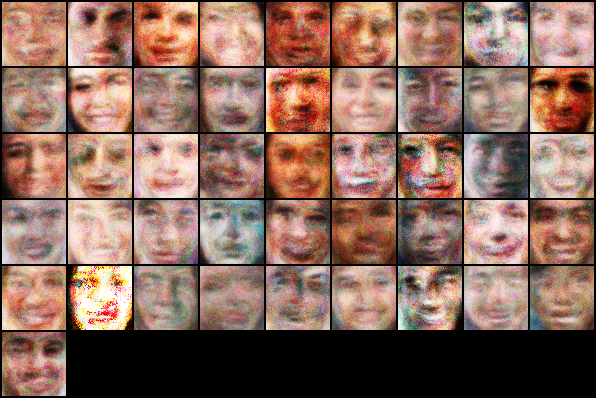

KeyboardInterrupt: 

In [10]:
%%time
run_epocs(5000)

# 07 - Sample Visualization

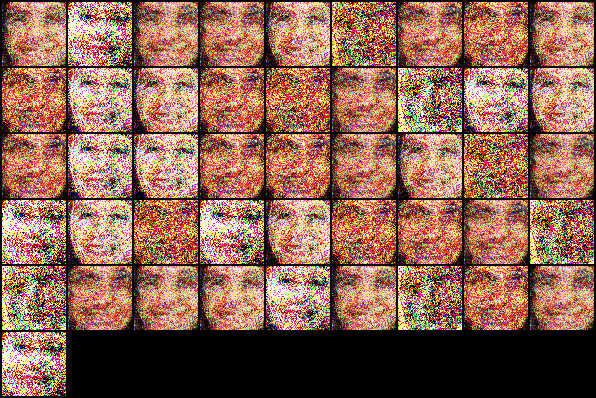

In [14]:
from IPython.display import Image

Image(filename="gan_images/test.png" )

# 08 - Visualizing Loss trhough the training

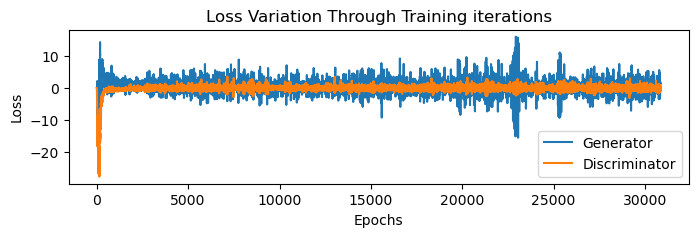

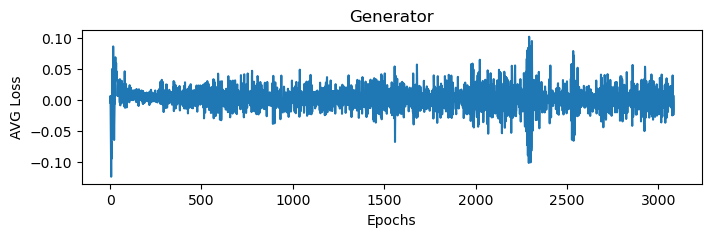

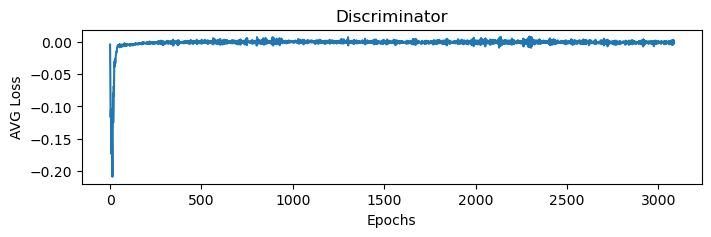

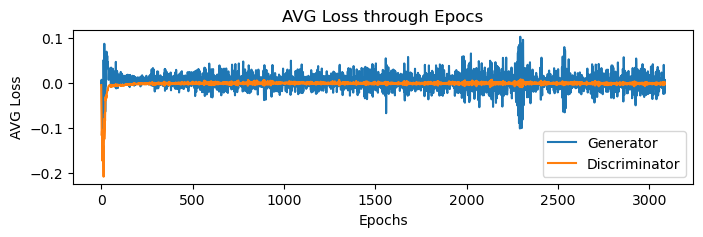

In [15]:
plt.figure(figsize=(8, 2))  
plt.plot(g_losses, label='Generator')
plt.plot(d_losses, label='Discriminator')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Variation Through Training iterations')
plt.show()

plt.figure(figsize=(8, 2))  
plt.plot(G_AVGLoss_list)
plt.xlabel('Epochs')
plt.ylabel('AVG Loss')
plt.title('Generator')
plt.show()

plt.figure(figsize=(8, 2))  
plt.plot(D_AVGLoss_list)
plt.xlabel('Epochs')
plt.ylabel('AVG Loss')
plt.title('Discriminator')
plt.show()

plt.figure(figsize=(8, 2))  
plt.plot(G_AVGLoss_list, label='Generator')
plt.plot(D_AVGLoss_list, label='Discriminator')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('AVG Loss')
plt.title('AVG Loss through Epocs')
plt.show()

## 09 - References

> This code is based on the previous week code that generates GAN ( ungraded week 9) that code was made using reference/ instructions from the Udemy course "PyTorch: Deep Learning and Artificial Intelligence" by "Lazy Programmer" and "Lazy programmer team"

> We used ChatGPT and Perplexity AI as co-pilots

The original assigniment had more steps and was finished in group, I just took the parts in wich i worked on as base and improved

The original work credits:

#### 2023F-T3 AISC2007 - Deep Learning 01

### CASE STUDY Week 10 

Teacher : **Bhavik Gandhi**

Group 2

Abin Benny
Fabio Duarte Junior
Liniya Sheen
Manish Chhetri
Megha Ann Mathew
Megha Malhotra
Niraj Rokaya
Sandesh Pandey
Sukriti Chhibber

October 2023, Loyalist College in toronto, Term 3, AI and data science post-graduation course. North York GTA, Ontario, campus Victoria Park

I also used perplexity AI and Chat-GPT as co-pilot for the Alexnet implementation and fix errors during the coding.

